# Introduction to the `embiggen` module

Luís F. Simões

*2019-01-22*

This notebook provides a demonstration of how to use the "`embiggen`" super-resolution module.

It was created for the European Space Agency's [PROBA-V super-resolution competition](https://kelvins.esa.int/proba-v-super-resolution/), hosted on the [Kelvins](https://kelvins.esa.int/) platform.

Below we'll use the module to perform some of the competition's basic tasks, such as: image loading, resizing, aggregation, scoring, results inspection and creating submissions.

----

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

----

Watermark of the environment in which this notebook was executed.

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,seaborn,scipy,skimage,PIL
# https://github.com/rasbt/watermark

CPython 3.5.3
IPython 6.4.0

numpy 1.14.5
pandas 0.23.3
matplotlib 2.2.2
seaborn 0.9.0
scipy 1.1.0
skimage 0.14.2
PIL 5.4.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


----

# Imports

In [2]:
from embiggen import *

In [3]:
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

----

# Getting the data

We start by downloading and extracting the competition's dataset of PROBA-V satellite images.

In [4]:
from urllib.request import urlretrieve
from zipfile import ZipFile

In [5]:
%%time
urlretrieve('https://kelvins.esa.int/media/competitions/proba-v-super-resolution/probav_data.zip',
            filename='probav_data.zip');

Wall time: 1min 51s


('probav_data.zip', <http.client.HTTPMessage at 0x1d7fc61b240>)

In [6]:
%%time
ZipFile('probav_data.zip').extractall('probav_data/')

Wall time: 1min 53s


Define a global constant pointing to the dataset's location:

In [7]:
DATA_PATH = 'probav_data/'

----

# `io`: listing and loading images

We can generate listings of all the scenes under a directory using **`all_scenes_paths()`**.

In [8]:
train = all_scenes_paths(DATA_PATH + 'train')
test  = all_scenes_paths(DATA_PATH + 'test')

len(train), len(test), len(train) + len(test)

(1160, 290, 1450)

In [9]:
train[:5]

['probav_data/train/RED/imgset0000',
 'probav_data/train/RED/imgset0001',
 'probav_data/train/RED/imgset0002',
 'probav_data/train/RED/imgset0003',
 'probav_data/train/RED/imgset0004']

**`scene_id()`** can be used to convert a scene's full path into a short identifier.

In [10]:
scene_id(train[0])

'imgset0000'

In [11]:
scene_id(train[0], incl_channel=True)

'RED/imgset0000'

Images can be loaded with **`highres_image()`** and **`lowres_image_iterator()`**.

The first returns a `(hr, sm)` tuple with the scene's high-resolution image and its corresponding status map.

In [12]:
hr, sm = highres_image(DATA_PATH + 'train/RED/imgset0393')

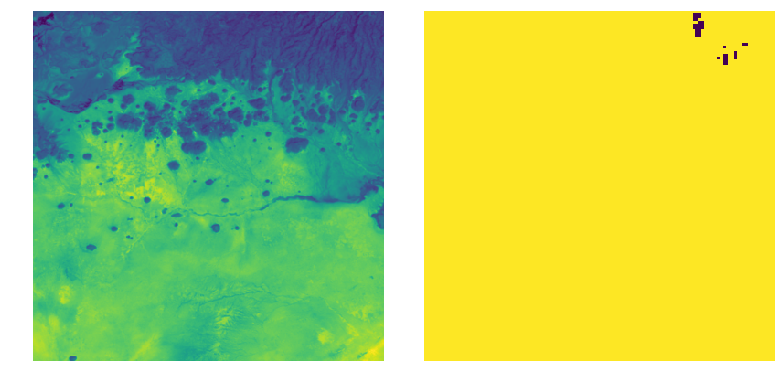

In [13]:
fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121); ax1.imshow(hr); ax1.axis('off');
ax2 = fig.add_subplot(122); ax2.imshow(sm); ax2.axis('off');
plt.tight_layout()

Similarly, `lowres_image_iterator()` returns `(lr, sm)` tuples with the scene's low-resolution images and their corresponding status maps.

Specifically, the function returns an iterator over all of the scene's low-resolution images.

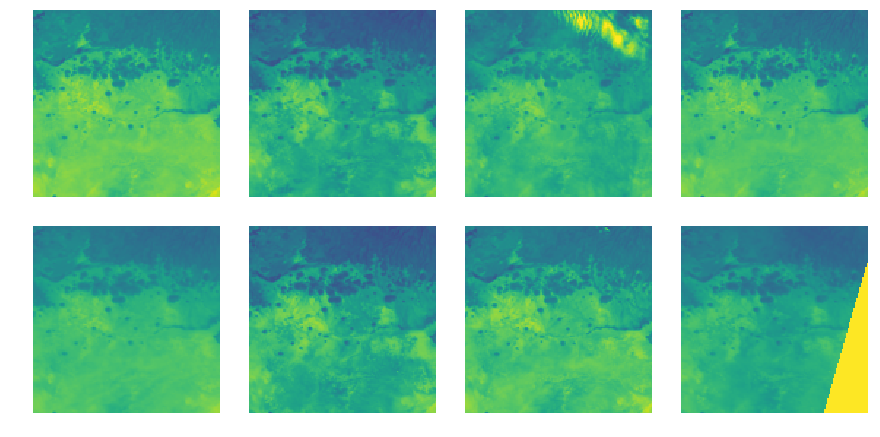

In [14]:
fig = plt.figure(figsize=(12, 6))

i = 0
for (lr, sm) in lowres_image_iterator(DATA_PATH + 'train/RED/imgset0393'):
    
    i += 1
    ax = fig.add_subplot(2, 4, i)
    ax.axis('off')
    
    ax.imshow(lr, vmin=0, vmax=0.2)
    
    if i == 8: break

fig.tight_layout(pad=0)

----

# `aggregate`: statistical image merges

The function **`central_tendency()`** aggregates sets of images through a statistical central tendency measure: mean, median or mode.

It can optionally aggregate only images' clear pixels. In the cases where the same pixels are obscured in all of the low-resolution images, the code can either leave gaps in the aggregated image or fill specifically those pixels with the aggregate of the values at the obscured pixels.

See the function's documentation for usage instructions.

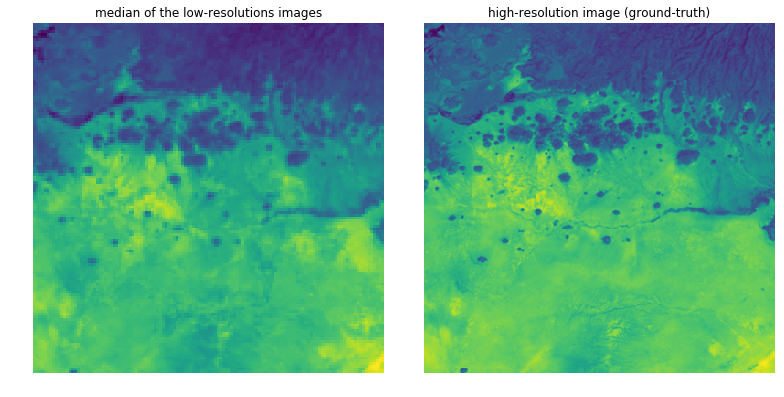

In [15]:
scene = DATA_PATH + 'train/RED/imgset0393'

ag = central_tendency(scene, agg_with='median', only_clear=False)

hr = highres_image(scene)[0]

fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121); ax1.imshow(ag); ax1.axis('off'); ax1.set_title('median of the low-resolutions images')
ax2 = fig.add_subplot(122); ax2.imshow(hr); ax2.axis('off'); ax2.set_title('high-resolution image (ground-truth)')

plt.tight_layout()

The function **`compare_aggregates()`** is provided to allow for visual inspection of how different aggregation approaches handle the data.

We compare here how `central_tendency()` aggregates the same scene's images if called with different settings.

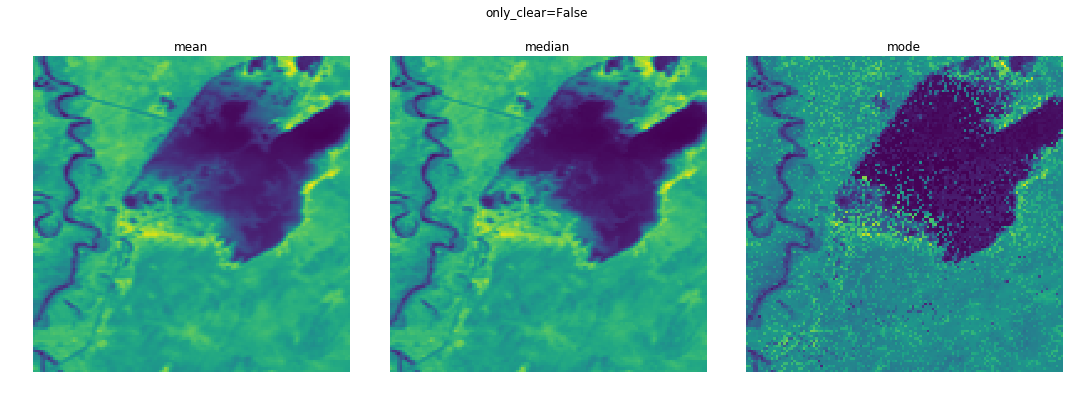

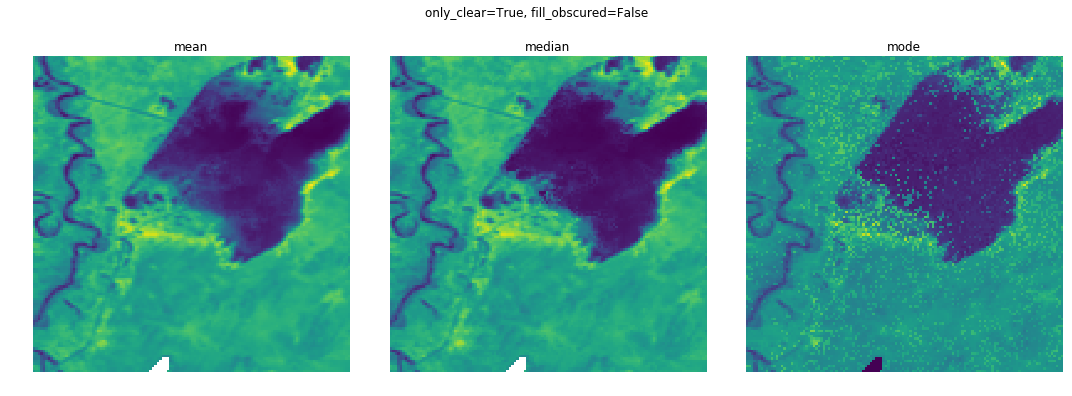

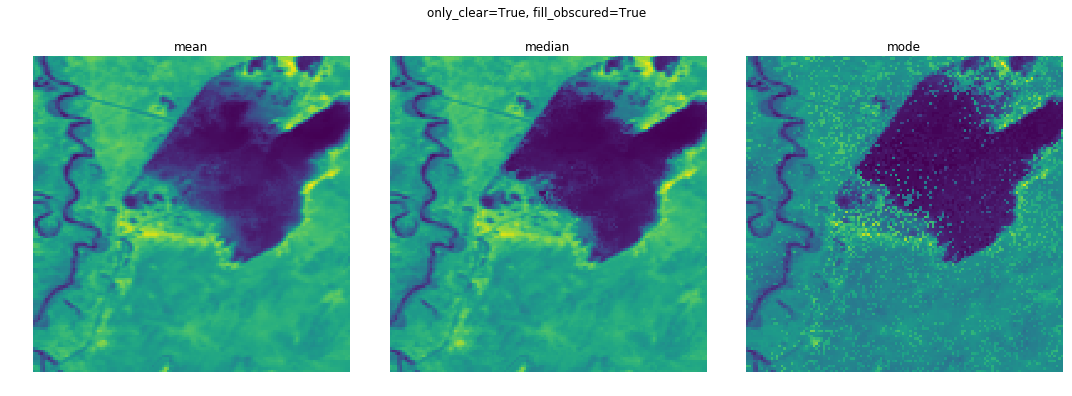

In [16]:
compare_aggregates(DATA_PATH + 'train/NIR/imgset1137');

---

**A peek at the dataset**

Below we take a look at the aggregates of a few interesting satellite images, to get a better sense of the kind of data we'll be working with.

In [17]:
kwargs = dict(clear_opts=[False])

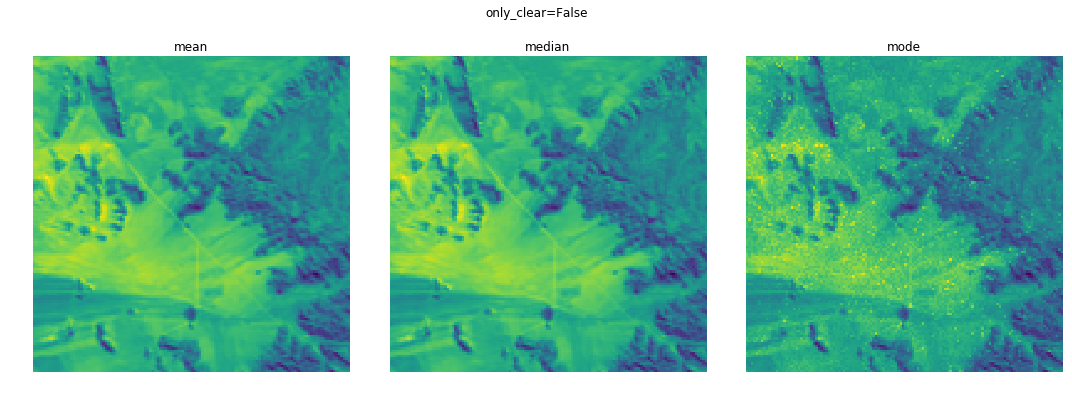

In [18]:
# "country roads"
# NIR channel, 18 images, most with very few occlusions
compare_aggregates(DATA_PATH + 'train/NIR/imgset1150', **kwargs);

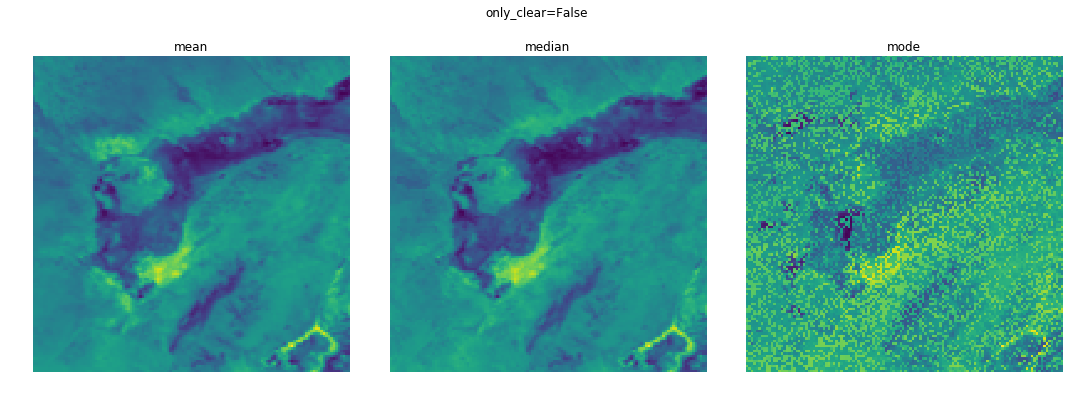

In [19]:
# "the old man and the river"
# RED channel, 17 images with considerable differences among them, apparent poor masking (example: LR005.png/QM005.png)
compare_aggregates(DATA_PATH + 'train/RED/imgset0102', **kwargs);

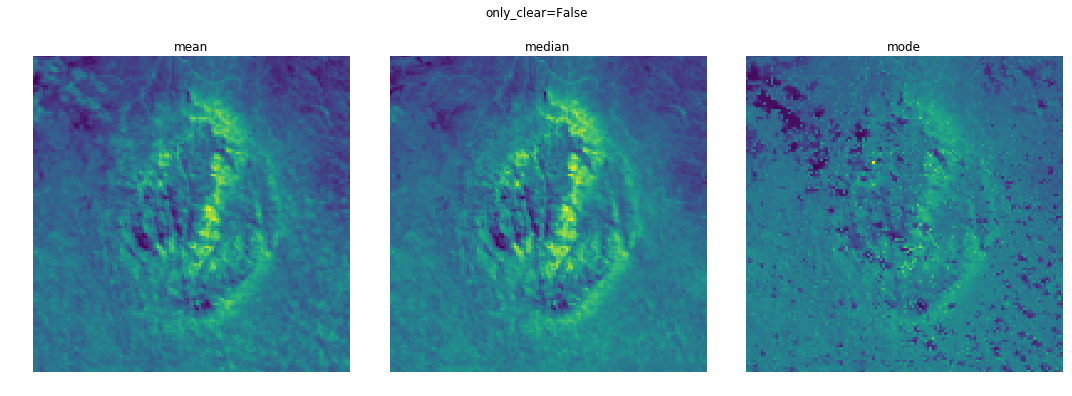

In [20]:
# "trilobite"
# NIR channel, 9 images (dataset minimum), many occlusions
compare_aggregates(DATA_PATH + 'train/NIR/imgset0703', **kwargs);

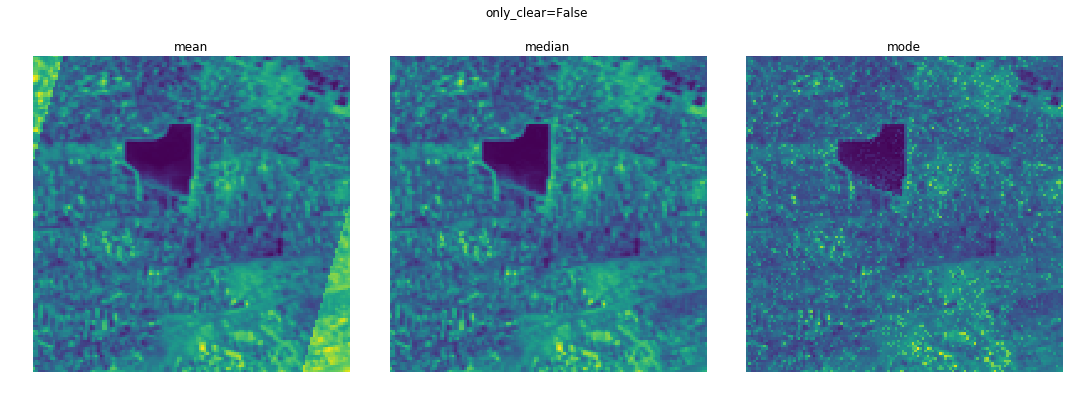

In [21]:
# "the city and the stars"
# RED channel, 26 images, not many occlusions
compare_aggregates(DATA_PATH + 'train/RED/imgset0216', **kwargs);

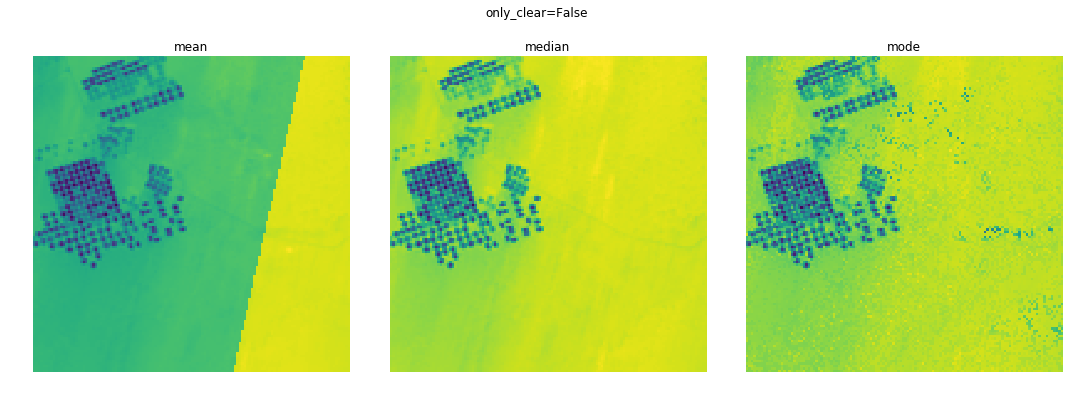

In [22]:
# cultivation fields with center pivot irrigation -- https://en.wikipedia.org/wiki/Center_pivot_irrigation
# NIR channel, 14 images, few occlusions
compare_aggregates(DATA_PATH + 'train/RED/imgset0503', **kwargs);

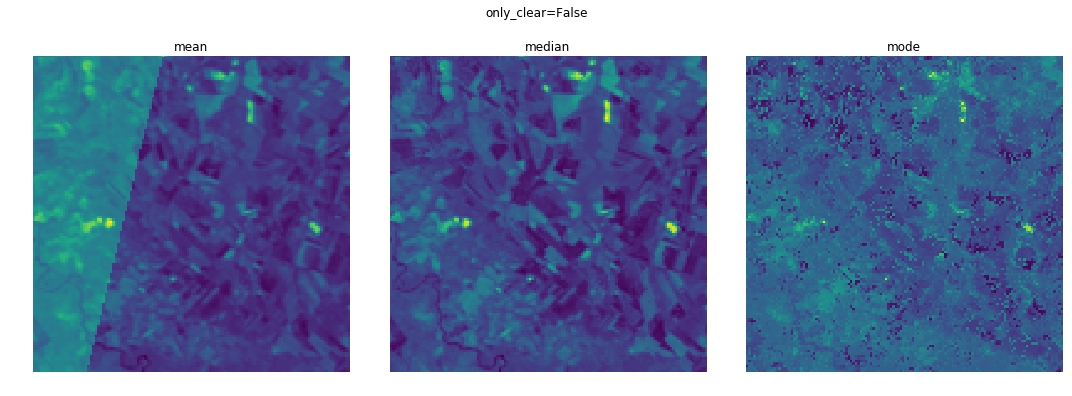

In [23]:
# cultivation fields
# NIR channel, 16 images with considerable differences among them (irrigation? harvesting?), moderate/high occlusions
compare_aggregates(DATA_PATH + 'train/NIR/imgset0639', **kwargs);

----

# `generate_sample_submission.py`

The competition organizers provided a script to generate an example submission ([here](https://kelvins.esa.int/proba-v-super-resolution/submission-rules/)).

We'll download and execute it here, before moving on.

In [24]:
py = 'generate_sample_submission.py'
urlretrieve('https://kelvins.esa.int/media/competitions/proba-v-super-resolution/' + py, filename=py);

In [25]:
%%time

outpath = './sample_submission'

!python {py} {DATA_PATH} {outpath}

generate sample solutions: **************************************************************************************************************************************************************************************************************************************************************************************************
archiving: 
**************************************************************************************************************************************************************************************************************************************************************************************************
done. The submission-file is found at ./sample_submission/submission.zip. Bye!
Wall time: 58.8 s


----

# `transform`: upscaling images

The image upscaling operations performed in `generate_sample_submission.py` can be reproduced through the functions **`bicubic_upscaling()`** and **`baseline_upscale()`**.

**`bicubic_upscaling()`** computes a bicubic upscaling by a factor of 3. It can be used to enlarge the 128x128 low-resolution images into the 384x384 dimensions of the high-resolution ones.

In [26]:
# load all of the scene's low-resolution images
scene = DATA_PATH + 'train/RED/imgset0393'
lrsm = list(lowres_image_iterator(scene))
len(lrsm)

17

In [27]:
# upscale one of the images
(lr, sm) = lrsm[2]

sr = bicubic_upscaling(lr)

lr.shape, sr.shape

((128, 128), (384, 384))

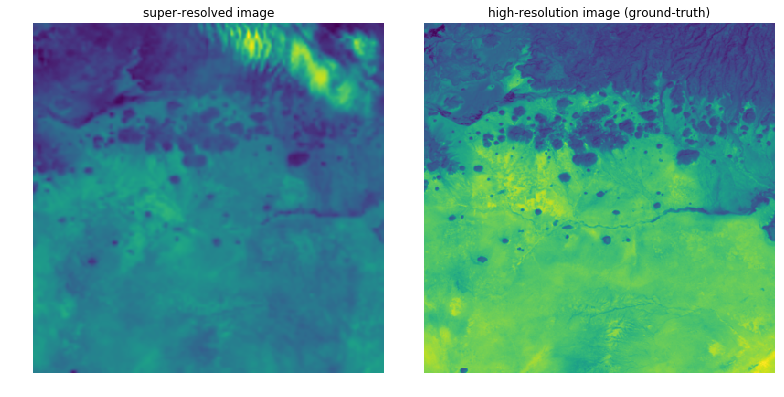

In [28]:
hr = highres_image(scene)[0]

fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121); ax1.imshow(sr); ax1.axis('off'); ax1.set_title('super-resolved image')
ax2 = fig.add_subplot(122); ax2.imshow(hr); ax2.axis('off'); ax2.set_title('high-resolution image (ground-truth)')

plt.tight_layout()

**`baseline_upscale()`** performs upscaling and aggregation through the same logic as in the provided `generate_sample_submission.py` file.

Upscale a scene from the test set:

In [29]:
scene = DATA_PATH + 'test/RED/imgset1207'

sr1 = baseline_upscale(scene)

Compare it against the upscaling of the same scene generated through `generate_sample_submission.py`:

In [30]:
sr2 = skimage.img_as_float64(skimage.io.imread('sample_submission/imgset1207.png'))

np.allclose(sr1, sr2, 1e-5, 1e-5), np.abs(sr1 - sr2).max()

(True, 7.61904522778023e-06)

----

# Scoring super-resolved images

The file `embiggen/score.py` provides an implementation of the competition's performance metric, "clear [Peak Signal to Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)", as defined [here](https://kelvins.esa.int/proba-v-super-resolution/scoring/).

It provides a number of variables and functions/classes that are presented below.

**`baseline_cPSNR`**: pandas DataFrame with the baseline cPSNR values for the dataset's images. Used for normalizing scores. Loaded from the file `norm.csv` that is included in the competition's dataset, and which was copied to the module's path for easier access.  `baseline_cPSNR` can be indexed by passing a scene's path through `scene_id()`.

In [31]:
baseline_cPSNR.head()

cPSNR
scene                
imgset0000  52.352173
imgset0001  46.464812
imgset0002  48.646021
imgset0003  45.709971
imgset0004  52.947346

**`score_image()`**: Calculates the individual score for a single super-resolved image.


In [32]:
scene = DATA_PATH + 'train/RED/imgset0393'

sr = baseline_upscale(scene)

score_image(sr, scene)

1.0000000000000002

**`score_images()`**: Measures the overall (mean) score across multiple super-resolved images.

In [33]:
train = all_scenes_paths(DATA_PATH + 'train')

# apply the baseline upscale over all of the train set's images
srs = [
    baseline_upscale(scene)
    for scene in tqdm(train)]

|##########| 1160/1160 100% [elapsed: 02:40 left: 00:00,  7.21 iters/sec]


In [34]:
# measure the overall score
score_images(srs, train)

|##########| 1160/1160 100% [elapsed: 02:39 left: 00:00,  7.27 iters/sec]


1.0

We get a perfectly rounded score of 1.0, as expected. This validates the implementations of the baseline upscale/aggregation, and crucially, of the scoring function. As noted in the competition's [submission rules](https://kelvins.esa.int/proba-v-super-resolution/submission-rules/) page:

> "The Scoring of these images (in terms of their cPSNR) constitutes our baseline of value 1 for ranking submissions. Thus, in order to improve upon bicubic upscaling, a submission needs to receive a score lower than 1."

There's an additional, better way to score images, through **`class scorer`**. It will be introduced in the next section.

----

# Beating the baseline

*... just barely :)*

In this section we perform a simple experiment to compare two approaches to super-resolution.

It serves to demonstrate usage of **`class scorer`**, and inspection of results through **`score_summary()`**.

In [35]:
help(scorer.__init__)

Help on function __init__ in module embiggen.score:

__init__(self, scene_paths, preload_hr=True)
    Wrapper to `score_image()` that simplifies the scoring of multiple
    super-resolved images.
    
    The scenes over which the scorer will operate should be given in
    `scene_paths`. This is either a sequence of paths to a subset of scenes
    or a string with a single path. In this case, it is interpreted as the
    base path to the full dataset, and `all_scenes_paths()` will be used to
    locate all the scenes it contains.
    
    Scene paths are stored in the object's `.paths` variable.
    When scoring, only the super-resolved images need to be provided.
    They are assumed to be in the same order as the scenes in `.paths`.
    
    If the object is instantiated with `preload_hr=True` (the default),
    all scene's high-resolution images and their status maps will be
    preloaded. When scoring they will be sent to `score_image()`, thus
    saving computation time in repeate

We start by creating an instance of the `scorer` class, meant for scoring super-resolved images of the full train set.

In [36]:
score = scorer(scene_paths=DATA_PATH + 'train/', preload_hr=True)

Preloading hi-res images: |##########| 1160/1160 100% [elapsed: 00:07 left: 00:00, 164.11 iters/sec]


`score.paths` can be accessed to list the paths to the scenes we'll be scoring.

In [37]:
len(score.paths)

1160

In [38]:
score.paths[:5]

['probav_data/train/RED/imgset0000',
 'probav_data/train/RED/imgset0001',
 'probav_data/train/RED/imgset0002',
 'probav_data/train/RED/imgset0003',
 'probav_data/train/RED/imgset0004']

Because the object was instantiated with `preload_hr=True`, the high-resolution images and their respective status maps are now in memory, and can be accessed through `score.hr_sm`.

In [39]:
ix = 1
print('(hr, sm) image for scene "%s".' % score.paths[ix])
hr, sm = score.hr_sm[ix]

(hr, sm) image for scene "probav_data/train/RED/imgset0001".


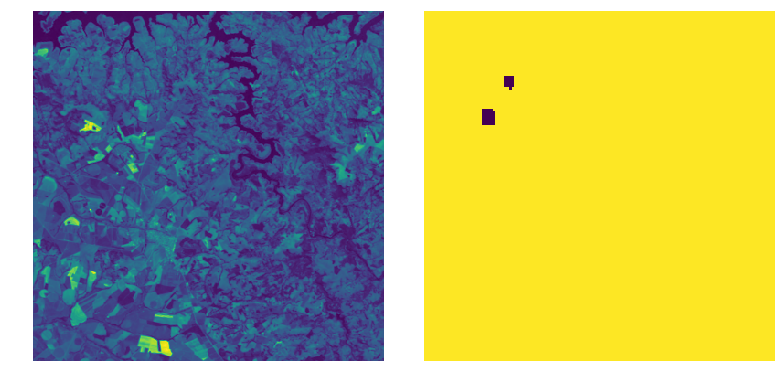

In [40]:
fig = plt.figure(figsize=(11,11))
ax1 = fig.add_subplot(121); ax1.imshow(hr); ax1.axis('off');
ax2 = fig.add_subplot(122); ax2.imshow(sm); ax2.axis('off');
plt.tight_layout()

----

Now we use `central_tendency()` to aggregate all of the train set's scenes, through two different approaches:
- `lr_median_all`: median of all pixel values;
- `lr_mean_clear`: mean value in clear pixels, with pixels that are always obscured taking the mean of those obscured values.

In both cases, we then apply `bicubic_upscaling()` so we're left with 384x384 super-resolved images.

In [41]:
lr_median_all = [
    central_tendency(scene_path, agg_with='median', only_clear=False)
    for scene_path in tqdm(score.paths, desc='aggregate')]

lr_median_all = [
    bicubic_upscaling(img)
    for img in tqdm(lr_median_all, desc='upscaling')]

aggregate: |##########| 1160/1160 100% [elapsed: 00:54 left: 00:00, 21.29 iters/sec]
upscaling: |##########| 1160/1160 100% [elapsed: 00:26 left: 00:00, 43.69 iters/sec]


In [42]:
lr_mean_clear = [
    central_tendency(scene_path, agg_with='mean', only_clear=True, fill_obscured=True)
    for scene_path in tqdm(score.paths, desc='aggregate')]

lr_mean_clear = [
    bicubic_upscaling(img)
    for img in tqdm(lr_mean_clear, desc='upscaling')]

aggregate: |##########| 1160/1160 100% [elapsed: 00:42 left: 00:00, 27.41 iters/sec]
upscaling: |##########| 1160/1160 100% [elapsed: 00:27 left: 00:00, 41.83 iters/sec]


Next we score the images generated through both approaches.

We could simply make a call of the form **`score(lr_median_all)`**, but we'll use the `per_image=True` argument so that in addition to the overall score we'll also get a second returned value: a list with the score per image.

In [43]:
sc1, lr_median_all_scores = score(lr_median_all, per_image=True); sc1

|#########-| 1156/1160  99% [elapsed: 02:34 left: 00:00,  7.50 iters/sec]

0.998985016169725

In [44]:
sc2, lr_mean_clear_scores = score(lr_mean_clear, per_image=True); sc2

|#########-| 1156/1160  99% [elapsed: 02:35 left: 00:00,  7.45 iters/sec]

0.9999321445989373

Two scores below 1.0. Both approaches outperform the baseline!

Because we have have the results per image, we can perform a more detailed analysis of the results. Enter **`score_summary()`**. We can either simply call as in `score_summary(lr_median_all_scores)`, or we can chain an arbitrary number of results (and optionally label them) to produce...

median of all  mean of clear
cPSNR                              
count    1160.000000    1160.000000
mean        0.998985       0.999932
std         0.032031       0.026426
min         0.839791       0.841296
25%         0.987431       0.993546
50%         1.001755       1.003730
75%         1.013288       1.012204
max         1.183506       1.116806

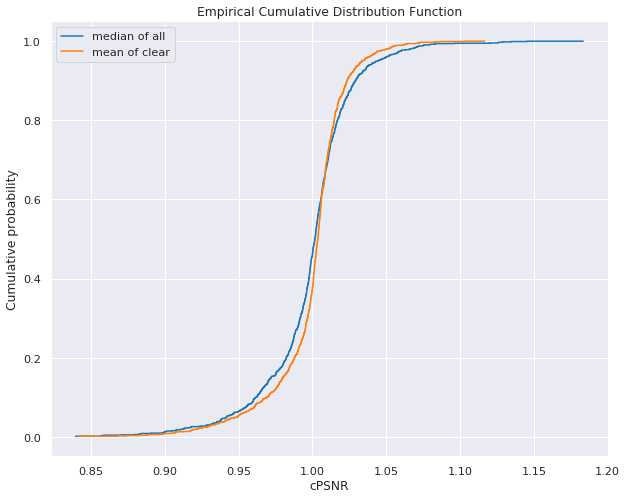

In [45]:
score_summary(
    lr_median_all_scores,
    lr_mean_clear_scores,
    labels=['median of all', 'mean of clear'])

This tells us that the "mean of clear" approach has better worst-case performance. It is however sadly bought at the expense of sacrificing best-case performance, resulting in worse overall score than in the "median of all" approach.

By matching the individual scores against `score.path` we can isolate the scenes where each approach works best/worst:

In [46]:
worst1 = sorted(zip(lr_median_all_scores, score.paths), reverse=True)

# (cPSNR, scene)
worst1[:15]

[(1.1835055385536852, 'probav_data/train/RED/imgset0559'),
 (1.1456729230475358, 'probav_data/train/NIR/imgset0630'),
 (1.1347502715215518, 'probav_data/train/RED/imgset0008'),
 (1.1288725699101334, 'probav_data/train/NIR/imgset0823'),
 (1.126581650186602, 'probav_data/train/RED/imgset0098'),
 (1.1257780267529327, 'probav_data/train/RED/imgset0393'),
 (1.1205333273832299, 'probav_data/train/NIR/imgset0880'),
 (1.0962144790655666, 'probav_data/train/NIR/imgset1137'),
 (1.0834731122070858, 'probav_data/train/NIR/imgset0617'),
 (1.0831426060961802, 'probav_data/train/NIR/imgset0848'),
 (1.0802943199754127, 'probav_data/train/NIR/imgset1027'),
 (1.0789978495533294, 'probav_data/train/NIR/imgset0884'),
 (1.0754652255137338, 'probav_data/train/NIR/imgset0668'),
 (1.0750948905114364, 'probav_data/train/RED/imgset0015'),
 (1.075063168123437, 'probav_data/train/RED/imgset0234')]

Let's take a look at where the approach fails the most:

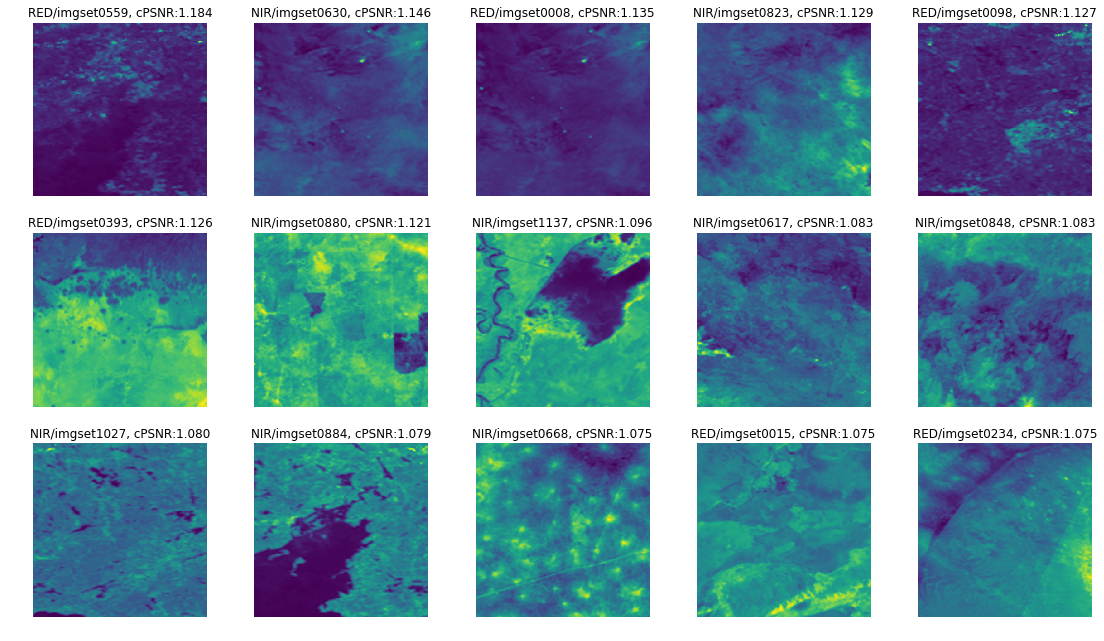

In [47]:
sr_imgs = dict(zip(score.paths, lr_median_all))

fig = plt.figure(figsize=(15, 9))
for i,(_score,_scene) in enumerate(worst1[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(sr_imgs[_scene])
    ax.set_title(scene_id(_scene, incl_channel=True) + ', cPSNR:%.3f' % _score)
    ax.axis('off')

fig.tight_layout(pad=0.05)
fig.subplots_adjust(left=0.01, right=.99, top=0.95)

#fig.savefig('img_panel.png')

----

# Preparing a submission

Having found above which of the approaches leads to a better overall (train set) score, all that's left is to apply the approach over the test set, and write our .zip file to submit in Kelvins...

In [48]:
test_set = all_scenes_paths(DATA_PATH + 'test')

In [49]:
lr_median_all = [
    central_tendency(scene_path, agg_with='median', only_clear=False)
    for scene_path in tqdm(test_set, desc='aggregate')]

lr_median_all = [
    bicubic_upscaling(img)
    for img in tqdm(lr_median_all, desc='upscaling')]

aggregate: |##########| 290/290 100% [elapsed: 00:34 left: 00:00,  8.41 iters/sec]
upscaling: |##########| 290/290 100% [elapsed: 00:06 left: 00:00, 43.52 iters/sec]


.zip files for submission can be prepared with **`prepare_submission()`**.

In [52]:
prepare_submission(lr_median_all, test_set, 'submission_01.zip')

Preparing submission. Writing to "submission_01.zip".
|##########| 290/290 100% [elapsed: 00:21 left: 00:00, 13.31 iters/sec]


----

This concludes our short tour. Hope you'll find this code useful.

Best of luck with the competition!

----

----

Generate the Table of Contents

In [53]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

----